In [139]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt



from itertools import cycle
import datetime as dt
import random 
import os
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import matplotlib.pyplot as plt




%matplotlib inline

 

In [140]:
import torch



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [142]:
import pandas as pd
import os


def extract_data(data_dir, file_name):
    table = pd.read_csv(os.path.join(data_dir, file_name)).drop("Date Time", axis=1)

    header = table.columns.values
    data = table.astype(float).values

    return header, torch.tensor(data, dtype=torch.float)


def normalize_data(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

In [143]:
# preprocessing

data_dir = "./jena_climate"
fname = "jena_climate_2009_2016.csv"
header, float_data = extract_data(data_dir, fname)
normalized_data = normalize_data(float_data)

In [144]:
print(header)

['p (mbar)' 'T (degC)' 'Tpot (K)' 'Tdew (degC)' 'rh (%)' 'VPmax (mbar)'
 'VPact (mbar)' 'VPdef (mbar)' 'sh (g/kg)' 'H2OC (mmol/mol)'
 'rho (g/m**3)' 'wv (m/s)' 'max. wv (m/s)' 'wd (deg)']


In [145]:
import numpy as np
import torch


def floating_window_batch_generator(
    data,
    sample_len,
    target_len,
    min_index,
    max_index,
    shuffle=False,
    batch_size=128,
    step=6,
):
    """
    Generate a batch of subsequences of data.

    Args:
        data: (samples, features)
        sample_len: number of samples in the past.
        target_len: number of samples to predict
        min_index: index of first sample
        max_index: index after the last sample
        shuffle: (boolean) if False, return batches in chronological order.
        batch_size: (int)
        step: (int) number of timesteps between samples
    """
    n_features = data.shape[-1]
    if max_index is None:
        max_index = len(data) - target_len - 1
    i = min_index

    window_size = (sample_len + target_len) * step

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index, max_index - (sample_len + target_len) * step, size=batch_size
            )
        else:
            if i + batch_size >= max_index - (sample_len + target_len) * step:
                i = min_index  # reset to beggining
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = torch.zeros((len(rows), sample_len, n_features))
        targets = torch.zeros((len(rows), target_len, n_features))
        for j, row in enumerate(rows):
            indices = range(row, row + window_size, step)
            samples[j] = data[indices[:sample_len]]
            targets[j] = data[indices[sample_len:]]

        yield samples, targets

In [146]:
sample_len = 120
step = 6
target_len = 24
batch_size = 128
selected_features = None

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)



In [147]:
def plot_samples(samples, targets, feature, figsize=(12, 12)):

    assert feature < samples.shape[-1]

    chosen_sample = samples[0, :, feature]
    chosen_target = targets[0, :, feature]

    plt.figure(figsize=figsize)
    sample_x = np.linspace(0, len(chosen_sample), len(chosen_sample))
    target_x = np.linspace(len(chosen_sample) + 1, len(chosen_sample) + len(chosen_target), len(chosen_target))

    plt.plot(sample_x, chosen_sample, color="red")
    plt.plot(target_x, chosen_target, color="black")

    plt.show()

In [148]:
samples, targets = next(train_generator)

In [149]:
print(samples.shape)
print(targets.shape)

torch.Size([128, 120, 14])
torch.Size([128, 24, 14])


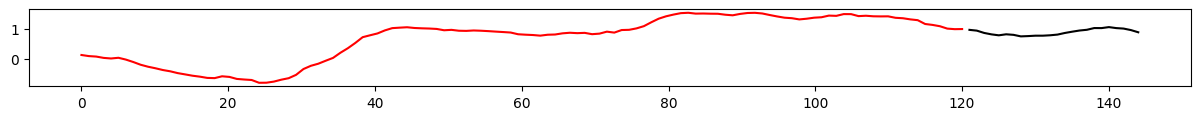

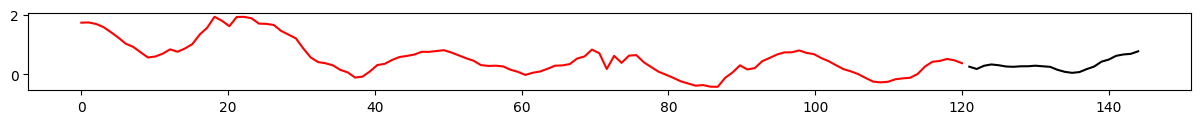

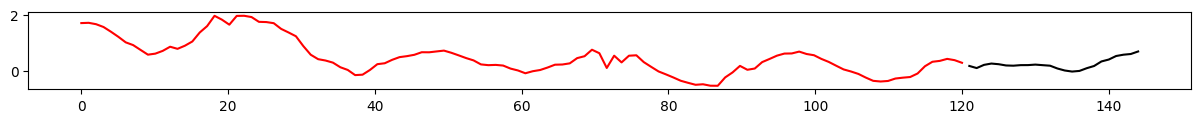

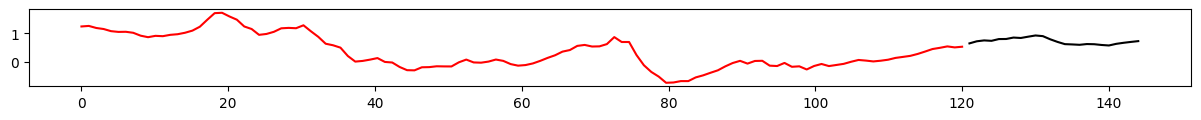

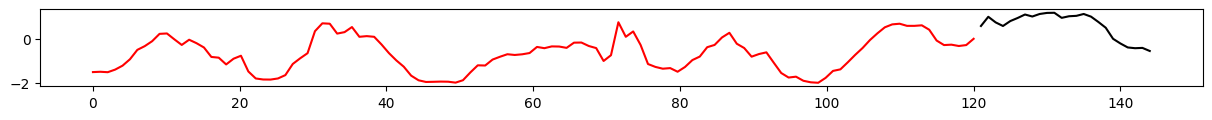

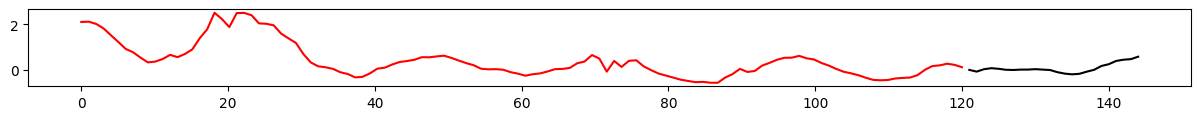

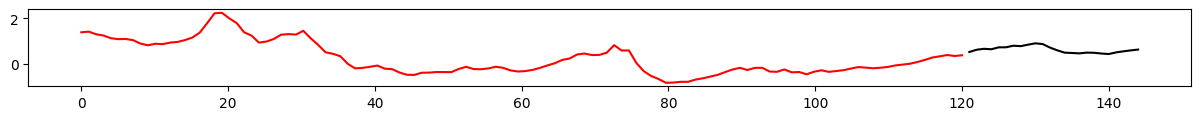

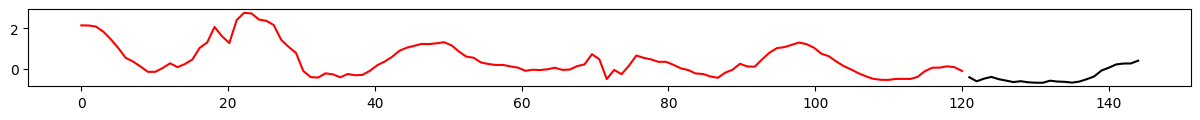

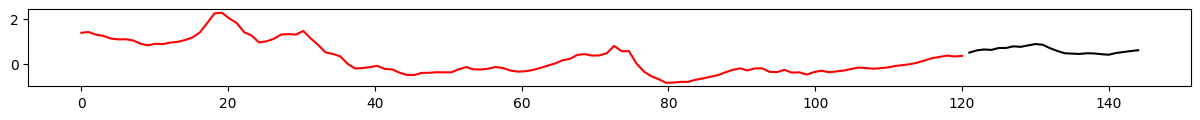

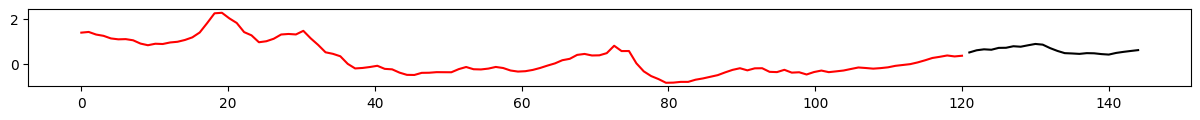

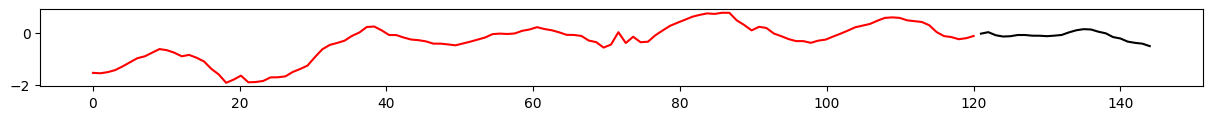

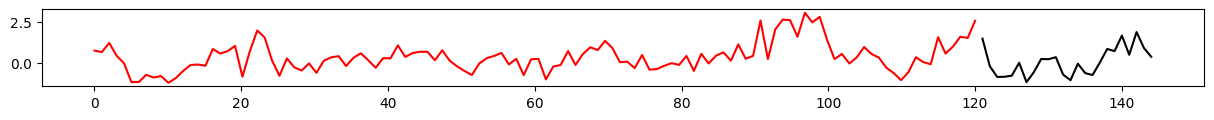

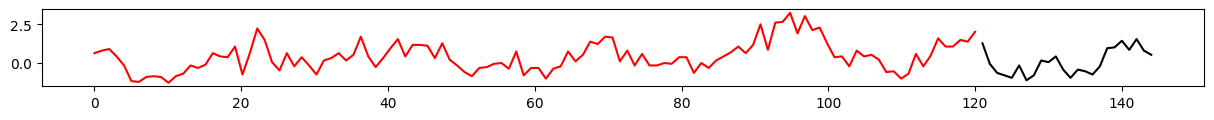

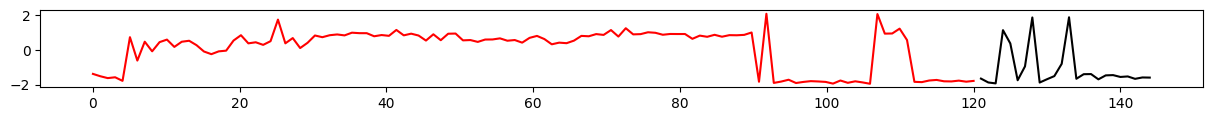

In [158]:

for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

In [151]:
class Encoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

    def forward(self, src):
        # src = [batch size, src len, n]

        outputs, (hidden, cell) = self.rnn(src)

        # outputs = [batch size, src len, hid dim * n directions]
        # hidden = [batch size, n layers * n directions, hid dim]
        # cell = [batch size, n layers * n directions, hid dim]

        # outputs are always from the top hidden layer

        return hidden, cell

In [152]:
class Decoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_features = n_features
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc_out = nn.Linear(hid_dim, n_features)

    def forward(self, input, hidden, cell):
        # input = [batch size, n features]
        # hidden = [batch size, n layers * n directions, hid dim]
        # cell = [batch size, n layers * n directions, hid dim]

        # n directions in the decoder will both always be 1, therefore:
        # hidden = [batch size, n layers, hid dim]
        # context = [batch size, n layers, hid dim]
        input = input.unsqueeze(1)
        # input = [batch size, 1, n features]

        output, (hidden, cell) = self.rnn(input, (hidden, cell))

        # output = [batch size, seq len, hid dim * n directions]
        # hidden = [batch size, n layers * n directions, hid dim]
        # cell = [batch size, n layers * n directions, hid dim]

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [batch size, 1, hid dim]
        # hidden = [batch size, n layers, hid dim]
        # cell = [batch size, n layers, hid dim]

        prediction = self.fc_out(output)

        # prediction = [batch size, n features]

        return prediction, hidden, cell

In [153]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch size, src len, n features]
        # trg = [batch size, trg len, n features]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        # tensor to store decoder outputs
        outputs = torch.zeros_like(trg).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        # first input to the decoder is the last sample
        input = src[:, -1]
        trg_len = trg.shape[1]

        for t in range(trg_len):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            output.squeeze_(1)

            # place predictions in a tensor holding predictions for each token
            outputs[:, t] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[:, t] if teacher_force else output

        return outputs

In [154]:
N_SAMPLES = float_data.shape[1]
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(N_SAMPLES, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(N_SAMPLES, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [155]:
print(model)
from torchinfo import summary

summary(
    model,
    input_size=[(10, sample_len, N_SAMPLES), (10, target_len, N_SAMPLES)],
    col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"],
    col_width=15,
)

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(14, 512, num_layers=2, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (rnn): LSTM(14, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=14, bias=True)
  )
)
src torch.Size([10, 120, 14])
trg torch.Size([10, 24, 14])
outputs torch.Size([10, 24, 14])
trg_len 24
t 0
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 1
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 2
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 3
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 4
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 5
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 6
output.shape torch.Size([10, 14])
torch.Size([10, 24, 14])
torch.Size([10, 14])
t 7
output.shape torch.Size([10, 14])
to

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Seq2Seq                                  [10, 120, 14]   [10, 24, 14]    --              True            --
├─Encoder: 1-1                           [10, 120, 14]   [2, 10, 512]    --              True            --
│    └─LSTM: 2-1                         [10, 120, 14]   [10, 120, 512]  3,182,592       True            --
├─Decoder: 1-2                           [10, 14]        [10, 1, 14]     --              True            --
│    └─LSTM: 2-2                         [10, 1, 14]     [10, 1, 512]    3,182,592       True            --
│    └─Linear: 2-3                       [10, 1, 512]    [10, 1, 14]     7,182           True            --
├─Decoder: 1-3                           [10, 14]        [10, 1, 14]     (recursive)     True            --
│    └─LSTM: 2-4                         [10, 1, 14]     [10, 1, 512]    (recursive)     True            --
│    └─Linear: 2-5

In [156]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,372,366 trainable parameters


In [ ]:
from tqdm import trange
import torch
import inspect


def train(dataloader, model, loss_fn, optimizer, size=None):

    assert not( inspect.isgenerator(dataloader) and size is None), "generator must have specified size"
    if size is None:
        size = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0
    average_acc = 0

    for _ in trange(size):
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        #y = y.unsqueeze(1).to(torch.float)
        # Compute prediction error

        pred = model(x,y)

        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= size

    return average_loss


def eval(dataloader, model, loss_fn, size=None):
    if size is None:
        size = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _ in trange(size):
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)
            #y = y.unsqueeze(1).to(torch.float)
            pred = model(x,y,teacher_forcing_ratio=0)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size

    return test_loss


import time


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    epochs=5,
    train_size=None,
    val_size=None
):
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            size=train_size,
        )
        print("Eval")
        test_loss = eval(
            val_dataloader, model, loss_fn=loss_fn, size=val_size
        )

        print(
            f"Train Error: Avg loss: {train_loss:>8f} "
        )
        print(
            f"Test Error: Avg loss: {test_loss:>8f} \n"
        )
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(test_loss)
        

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    print(f"Total Duration: {total_duration:.2f}")
    average_duration = total_duration / epochs
    print(f"Average Duration: {average_duration:.2f}")
    return history

In [ ]:
from typing import Dict, List

import matplotlib.pyplot as plt
# model plot
def plot_history(history:Dict[str, Dict[str, List]]):

    val_data = history['val']
    train_data = history['train']
    nr_metrics = len(train_data.keys())
    fig = plt.figure(figsize=(8, 4*nr_metrics))

    for i, name in enumerate(train_data.keys()):
        ax = fig.add_subplot(nr_metrics, 1, i + 1)
        plt.plot(train_data[name], label='train ' + name, color='b')
        plt.plot(val_data[name], label='val ' + name, color='r')
        plt.title(name)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    
    plt.show()    
    


In [ ]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_size=100,
    val_dataloader=val_generator,
    val_size=20,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=15,
)

Epoch 1
-------------------------------
Test


  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:02<00:07, 10.11it/s]


KeyboardInterrupt: 

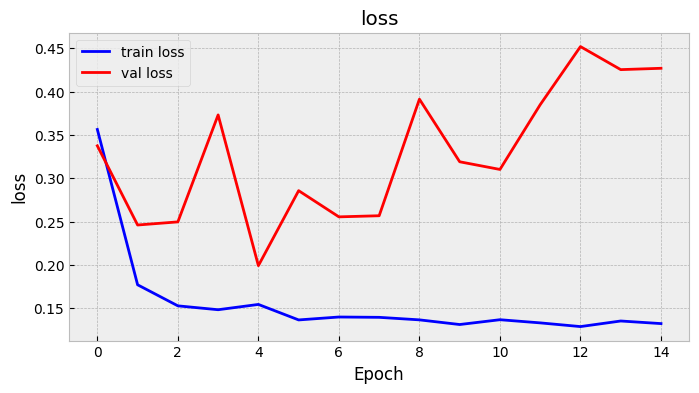

In [ ]:
plot_history(history)

In [ ]:
def make_predictions(model, samples, targets):
    with torch.no_grad():
        output = model(samples.to(device), targets.to(device), teacher_forcing_ratio=0)
    return output

def plot_predictions(samples, targets, output):
    
    for feature in range(samples.shape[-1]):
        print(header[feature])
        temp_sample = samples[0, :, feature]
        temp_target = targets[0, :, feature]
        temp_output = output[0, :, feature].cpu().detach()
        plt.figure(figsize=(20, 4))
        plt.plot(
           torch.cat((temp_sample, temp_target), dim=0), color="black", label="Ground Truth"
        )
        plt.plot(
            torch.cat((temp_sample, temp_output), dim=0), color="red", label="Prediction"
        )
        plt.legend()
        plt.show()



torch.Size([128, 24, 14])
torch.Size([120])


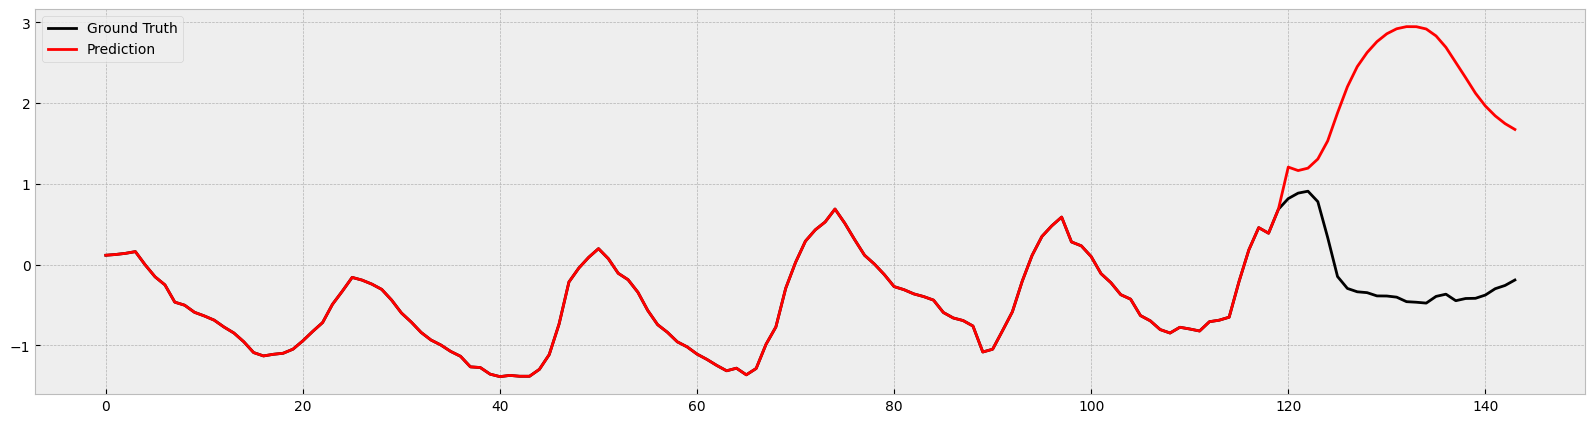

In [ ]:
model.eval()
samples, targets = next(train_generator)
output = make_predictions(model, samples, targets)
print(output.shape)

plot_predictions(samples, targets, output)